# Markov Networks and Conditional Random Fields

**COMP9418-20T3, W07 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney 
- Questions by Gustavo Batista

In this week's tutorial, we will explore the class of undirected graphs known as *Markov networks* or *Markov Random Fields*. These networks are used to model symmetrical dependencies between random variables. These models are particularly popular in areas such as image and language processing.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run these commands:

```python
pip3 install numpy matplotlib
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed. If you do not have it and use the conda installation, then use the command ```conda install python-graphviz```.

Once you have done all that, you can import some useful modules for later use.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Libraries for creating and assessing machine learning classifiers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# combinatorics
from itertools import product, combinations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
# table formating for screen output
from tabulate import tabulate
# visualise graphs
from graphviz import Digraph
# clear display
from IPython import display
# access to math.log2
import math
# random number generator
import random as rnd
import string

# Image smoothing
Let's start illustrating how Markov networks work with image smoothing. Remember that image smoothing is the process of removing random noise from an image. For instance, pictures taken in low illumination conditions frequently appear *pixelated*.

We start loading one image we will use to test our Markov network.

Image size:
256 x 256


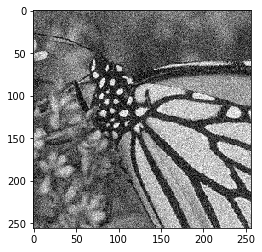

In [2]:
img_noisy=mpimg.imread('img/05_25_noisy.png')
plt.imshow(img_noisy, cmap='gray')
(size_x, size_y) = img_noisy.shape
print("Image size:")
print(size_x, "x", size_y)

We can see this is a small 256 x 256 grayscale image. The colour values are numbers between 0 and 255. Even for a small image like this, we need to be careful with our implementation. Otherwise, we can end up with a code that is too slow or use too much memory. Our Markov networks will use the following graph structure.

![](./img/image_graph.png)

Where $Y_{i,j}$ is the input (noisy) image and $X_{i,j}$ is the output (filtered) image. To represent both images, we will use 2-dimensional matrices (256 x 256) instead of factors.

Also, our model will have two forms of pairwise potentials:
1. $\psi(X_{i,j}, X_{i',j'})$ represents the correlations between neighbouring pixels.
2. $\psi(X_{i,j}, Y_{i,j})$ describes the correlations between pixels in the same position in the noisy and filtered images.

The final component of our model is the energy function. In general, the energy function has the following format:

$$E(\textbf{X})=\sum_{c\in Cliques(G)}\psi_c(\textbf{X}_c)$$

Let's instantiate this energy function to our problem. Our cliques are pairwise connections between pixels. We will assume the neighboring pixes are in the positions $(i-1, j), (i+1, j), (i, j-1), (i, j+1)$. Therefore, we have:

$$E(\textbf{X})=\sum_{i,j}\psi(X_{i,j}, Y_{i,j})+\psi(X_{i,j}, X_{i+1,j})+\psi(X_{i,j}, X_{i,j+1})$$


## Stochastic Search

We will now implement the image smoothing using Markov networks. We will develop a stochastic search algorithm, as described in the lecture.

This algorithm will choose one pixel and change its value. If such a change decreases the total image energy, we will accept the change. Otherwise, the change will be ignored, and we move to another pixel. Besides, the algorithm will accept changes that increase the energy with a small probability of $p$ in an attempt to avoid local minima.

Remember that our objective is to compute an MPE query (we are interested in the filtered image with the highest probability/smallest energy). Therefore, the stochastic search algorithm will move towards a (local) minima through a series of changes in the pixel values.

To improve the code efficiency, we note that a change in a single pixel can only affect the pixel neighbourhood. Therefore, we will only compute the following function to assess the difference in the energy function:

$$\Delta E(\textbf{X})=\psi(X_{i,j}, Y_{i,j})+\psi(X_{i,j}, X_{i+1,j})+\psi(X_{i,j}, X_{i,j+1})+\psi(X_{i,j}, X_{i-1,j})+\psi(X_{i,j}, X_{i,j-1})$$

Let's start defining some helper functions.

In [3]:
### This helper function converts a number between 0 and x*y into an (x,y) coordinate
def int_to_coord(pos, size_y):
    """
    argument 
    `pos`, a position expressed as an integer number between 0 and image's size_x * size_y
    `size_y`, number of columns of the image matrix
    
    Returns pos converted into a (x, y) coordinate
    """
    return int(pos / size_y), pos % size_y

# This helper function returns a list with the neighbours of a (x, y) pixel respecting the image limits
def neighbours(x, y, size_x, size_y):
    """
    argument 
    `x, y`, pixel coordinate
    `size_x, size_y`, image size
    
    Returns a list with valid (x, y) neighbours
    """
    
    neighbours = list()
    if x > 0:
        neighbours.append((x-1, y))
    if x < size_x - 1:
        neighbours.append((x+1, y))
    if y > 0:
        neighbours.append((x, y-1))
    if y < size_y - 1:
        neighbours.append((x, y+1))
    return neighbours

# This helper function defines energy between two data points
def energy_point(x, y):
    """
    argument 
    `x, y`, pixel color [0,255] range

    Returns the absolute difference between x and y. Other measures of dissimilarity may also work such as (x - y)**2
    """    
    return abs(x - y)
    
# This helper function plots the results every 10 iterations so we can see the convergence
def plot_results(it, image_x, image_y, energies, max_iter):
    """
    argument 
    `it`, current iteraction
    `image_x`, filtered image
    `image_y`, observed image
    `energies`, list of energy values computed for each iteration
    `max_iter`, maximum number of iterations
    """    
    
    (size_x, size_y) = image_y.shape
    energy = sum([energy_point(image_x[x][y], image_y[x][y]) for x in range(size_x) for y in range(size_y)])
    energy += sum([energy_point(image_x[x][y], image_x[x+1][y]) for x in range(size_x-1) for y in range(size_y)])
    energy += sum([energy_point(image_x[x][y], image_x[x][y+1]) for x in range(size_x) for y in range(size_y-1)])
    energies.append(energy)               
    if it % 10 == 0:
        display.clear_output(wait=True)
        print("Iteration:")
        print(it)
        plt.figure(figsize=(10, 10))
        plt.subplot(2, 1, 1)
        axes = plt.gca()
        axes.set_xlim([0, max_iter])
        axes.set_ylim([min(max(energies)/2,min(energies)), max(energies)])
        plt.plot(energies, 'ro')
        plt.subplot(2, 2, 3)
        plt.imshow(image_y, cmap='gray') 
        plt.subplot(2, 2, 4)    
        plt.imshow(image_x, cmap='gray') 
        plt.show()

## Exercise

Now, it is your turn. Let's implement a stochastic search. We have created a stub for you. You only need to fill in a few gaps. (This function will take a while, give it >20 seconds to produce output).

In [12]:
def stochastic_search(image_y, max_iter=101, eps=.001, step_stdev=.05):
    """
    argument 
    `image_y`, observed image
    `max_iter`, maximum number of iteractions
    `eps`, probability of accepting a higher energy change
    `step_stdev`, standard deviation. Changes are randon numbers from a Gaussian distribuion N(0, step_stdev)
    """
    
    # List of energy values for each iteration. Initialise with empty list
    energies = []
    # Image size expressed as number of rows and columns
    (size_x, size_y) = image_y.shape
    # Image size expressed as number of pixels
    size = size_x * size_y
    # Let's use image_y as starting point for image_x. It will be faster than if we start with a random assignment
    image_x = image_y.copy()

    for it in range(max_iter):
        # order has the indexes of all pixels in the image
        order = list(range(size))
        # Let's shuffle these indexes so each pass will use a different order
        rnd.shuffle(order)
        for o in order:
            # Use the int_to_coord helper function to convert o into an (x,y) coordinate
            (x, y) = None                                                                       # 1 line
            # Use energy_point to initialise energy_prev with the energy between image_x and image_y in the same pixel position (x, y)
            energy_prev = None                                                                  # 1 line
            # step defines the change in image_x pixel. We will use a random value from a normal distribution with mean zero and a small standard deviation
            step = rnd.gauss(0, step_stdev)
            # Use energy_point to initialise energy_post with the energy between image_x +step and image_y in the same pixel position (x, y)
            energy_post = None                                                                  # 1 line
            # Use neighbours to find all valid neighbours of the current pixel
            for (i, j) in neighbours(x, y, size_x, size_y):
                # Use energy_point to update energy_prev for each neighbour pixel
                energy_prev += None                                                             # 1 line
                # Use energy_point to update energy_post for each neighbour pixel
                energy_post += None                                                             # 1 line
            # Update image_x if the change led to an decrease of energy    
            if energy_post < energy_prev or rnd.random() < eps:
                image_x[x][y] += step
        # Call plot_results to show the progress so far
        plot_results(it, image_x, image_y, energies, max_iter)

##################
# Test code

stochastic_search(img_noisy)

TypeError: cannot unpack non-iterable NoneType object

Iteration:
100


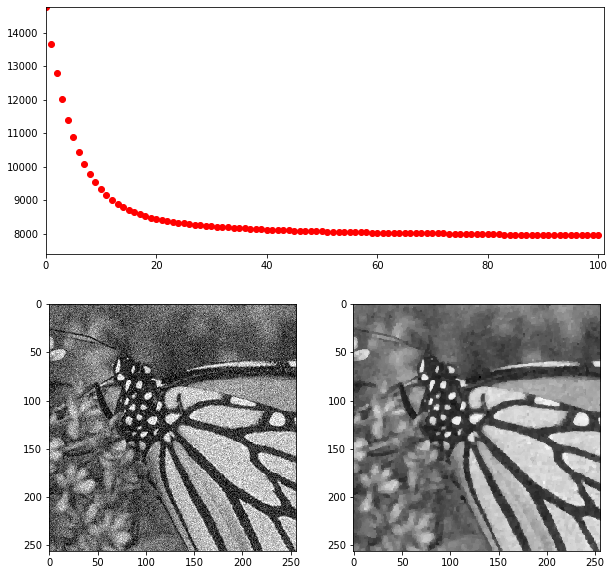

In [4]:
# Answer

def stochastic_search(image_y, max_iter=101, eps=.001, step_stdev=.05):
    """
    argument 
    `image_y`, observed image
    `max_iter`, maximum number of iteractions
    `eps`, probability of accepting a higher energy change
    `step_stdev`, standard deviation. Changes are randon numbers from a Gaussian distribuion N(0, step_stdev)
    """
    
    # List of energy values for each iteration. Initialise with empty list
    energies = []
    # Image size expressed as number of rows and columns
    (size_x, size_y) = image_y.shape
    # Image size expressed as number of pixels
    size = size_x * size_y
    # Let's use image_y as starting point for image_x. It will be faster than if we start with a random assignment
    image_x = image_y.copy()

    for it in range(max_iter):
        # order has the indexes of all pixels in the image
        order = list(range(size))
        # Let's shuffle these indexes so each pass will use a different order
        rnd.shuffle(order)
        for o in order:
            # Use the int_to_coord helper function to convert o into an (x,y) coordinate
            (x, y) = int_to_coord(o, size_y)
            # Use energy_point to initialise energy_prev with the energy between image_x and image_y in the same pixel position
            energy_prev = energy_point(image_x[x][y], image_y[x][y])
            # step defines the change in image_x pixel. We will use a random value from a normal distribution with mean zero and a small standard deviation
            step = rnd.gauss(0, step_stdev)
            # Use energy_point to initialise energy_post with the energy between image_x +step and image_y in the same pixel position
            energy_post = energy_point(image_x[x][y] + step, image_y[x][y])
            # Use neighbours to find all valid neighbours of the current pixel
            for (i, j) in neighbours(x, y, size_x, size_y):
                # Use energy_point to update energy_prev for each neighbour pixel
                energy_prev += energy_point(image_x[x][y], image_x[i][j])
                # Use energy_point to update energy_post for each neighbour pixel
                energy_post += energy_point(image_x[x][y] + step, image_x[i][j])
            # Update image_x if the change led to an decrease of energy    
            if energy_post < energy_prev or rnd.random() < eps:
                image_x[x][y] += step
        # Call plot_results to show the progress so far
        plot_results(it, image_x, image_y, energies, max_iter)

##################
# Test code

stochastic_search(img_noisy)

# Conditional Random Fields (CRFs)

Conditional Random Fields are *discriminative* graphical models. These models are a very popular way to integrate the output of multiple independent classifiers into a more complex structured prediction.

A simple example is the classification of sequences. As the next figure illustrates:

![](./img/chain_CRF.png)

This is a *linear chain CRF* in which we want to predict an entire word given predictions for individual letters.

In this part of the tutorial, we will implement this application of word prediction using Machine Learning classifiers trained to recognise individual letters.

Let's start by reading the dataset. It is a large dataset of handwritten letters made available in a [Kaggle competition](https://www.kaggle.com/ponrajsubramaniian/az-handwritten-digits). 

This dataset may take a while to load. If your computer has a few GB of memory free, use the larger dataset 'data/A_Z_Handwritten_Data.csv'. If not, use the smaller dataset 'data/A_Z_Handwritten_Data_Small.csv'.

In [5]:
dataset = np.loadtxt('data/A_Z_Handwritten_Data.csv', delimiter=',')

OSError: data/A_Z_Handwritten_Data.csv not found.

This is a reasonably large set of handwritten characters, let's see how many examples and attributes we have.

In [10]:
(num_examples, num_attributes) = dataset.shape
print("Number of examples", num_examples)
print("Number of attributes", num_attributes)

Number of examples 26000
Number of attributes 785


The first attribute is the class label, encoded as 0 = 'a', 1 = 'b', and so on. Let's remove this column from the data, so there will be no risk of incorrectly providing this information to the classifier as a regular feature.

In [11]:
X = dataset[:,1:785]
Y = dataset[:,0]

Also, the following helper function will be handy when we need to convert the class numbers 0-25 into letters a-z.

In [12]:
def num_to_letter(n):
    return string.ascii_lowercase[int(n)]

################
# Test code

for i in range(26):
    print(num_to_letter(i), end='')

abcdefghijklmnopqrstuvwxyz

Let's now split the dataset into training and test sets. We use a 50%-50% split since we have plenty of data.

In [13]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.50)

The data is provided as a CSV file with 784 attributes. Now, we convert the data to 28 x 28-pixel images so that we can visualise part of the dataset. Notice that we created new variables `X_train_img` and `X_test_img` to preserve the original data for training and testing the models.

In [14]:
# Reshape images, from 1 x 784 to 28 x 28
X_train_img = X_train.reshape(X_train.shape[0], 28, 28).astype('float32')
X_test_img = X_test.reshape(X_test.shape[0], 28, 28).astype('float32')

# The pixel values are numbers in the range 0..255. We need to convert into 0..1 range
X_train_img = X_train_img / 255
X_test_img = X_test_img / 255

The next cell plots some random images so that we can have a better feeling of the appearance of the handwritten letters.

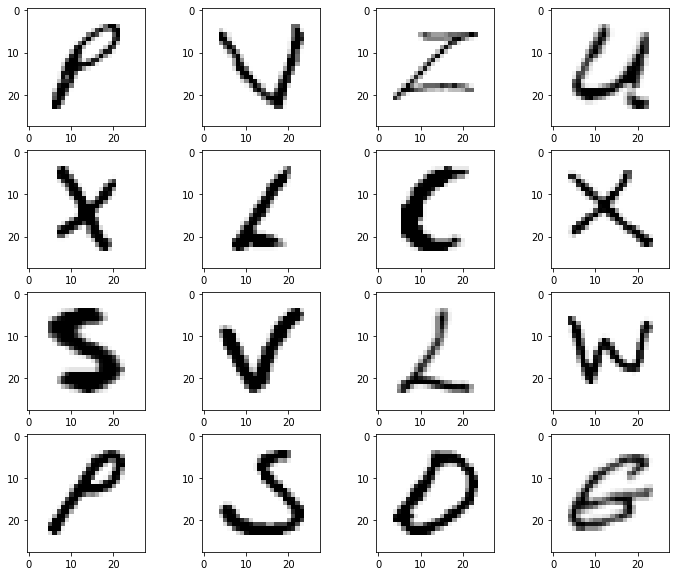

In [15]:
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_train_img[i],interpolation='nearest', cmap='Greys')
plt.show()

## Machine Learning classifier for recognition of individual letters

We have loaded and prepared our data. It is time to build some models. We can create any model we want, and you are invited to test different models later on.

In this part of the tutorial, we will use Random Forests (RF) as classifiers for several reasons:

1. They are simple to train. Although RFs have several hyperparameters, they often provide very good results with default parameter values.
2. They are naturally multiclass. Since we have 26 classes, it is simpler to deal with a classifier that can handle all of them, instead of converting the data into multiple binary-class datasets.
3. They frequently provide competitive classification accuracy compared to other state-of-the-art Machine Learning classifiers.

A downside is that Random Forests are ensemble classifiers that typically use a few hundred trees. Therefore, they tend to be slow for training and classification. 

The next cell will build a model. Since we have a large dataset, we will limit the number of trees to 100. You can play with this and other settings later on. The next cell will take a while to run.

In [16]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

[[478   2   0   0   0   0   0   0   0   1   1   0   6   3   0   3   2   2
    0   0   0   0   0   3   1   0]
 [  6 448   0  16   4   0   4   0   0   0   0   0   1   1   1   1   3   6
    1   0   0   0   0   1   0   3]
 [  0   2 458   0   3   0   5   0   0   1   2   6   1   1   5   2   0   3
    0   0   1   0   0   0   0   0]
 [  2   2   0 443   0   0   1   0   0   2   0   0   1   2  39   7   4   1
    1   0   0   0   1   0   0   1]
 [  4   4  15   0 439   4  10   1   0   0   7   9   0   0   0   4   2   7
    2   0   2   0   1   0   1   3]
 [  1   0   1   0   0 479   0   0   0   0   2   0   0   0   0   4   0   1
    1   1   0   0   0   0   0   0]
 [  6   9   5   1   5   3 444   1   0   3   3   3   6   1   2   0  20   0
    2   0   1   0   4   0   0   0]
 [ 11   1   0   2   1   0   1 418   0   0   5   0   3  25   0   1   1   2
    0   0   6   0   1   2   4   0]
 [  0   0   0   0   1   0   1   0 493   3   0   0   0   0   0   0   0   0
    0   2   0   0   0   0   0   0]
 [  0   1   0   4  

You can inspect the performance results to check the classes that are frequently misclassified. We can also see that the overall performance is quite good, typically above 97% accuracy. (Around 90% for small dataset)

## Making words

Unfortunately, our dataset does not have words, only handwritten characters. Therefore, we will have to develop a series of functions to produce words from characters. We start with a helper function that creates a Python dictionary. The dictionary keys are letters (a-z), and the items are lists with the indexes of the handwritten characters in the *test* set.

Some examples of letters 'a' in the test set


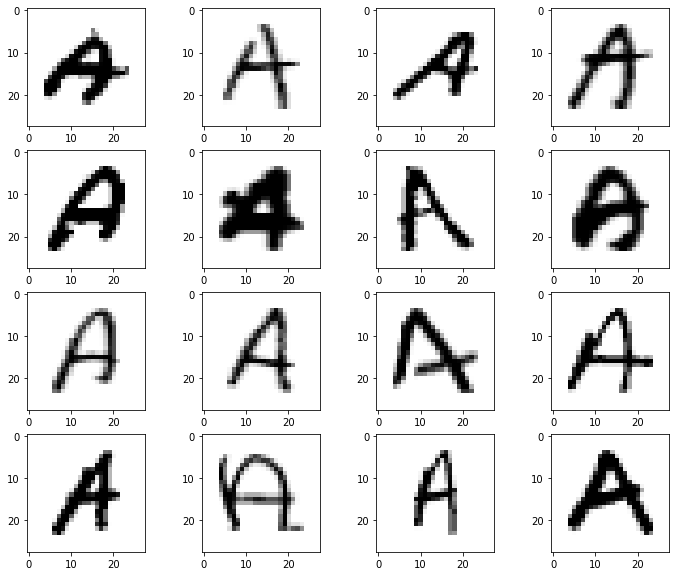

In [37]:
# Helper function, creates a python dictionary maping lowercase letters to indexes of examples in the test set

def letter_idxs():
    letters = {}
    for i in range(26):
        letters[num_to_letter(i)] = []
    for i in range(len(Y_test)):
        letters[num_to_letter(Y_test[i])].append(i)
    return letters

#################
# Test code

letters = letter_idxs()
print("Some examples of letters 'a' in the test set")
plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_test_img[letters['a'][i]],interpolation='nearest', cmap='Greys')
plt.show()

We use the letters dictionary to create words composed by the handwritten characters in the test set. We will use these words to test our classifiers. The next helper function produces a sequence of character images given a string. We randomly pick a letter from the test set.

In [38]:
# This helper function converts an string into a sequence of indexes of test set examples. The indexes are randomly chosen by respect the letters in the string

def make_word(word, letters):
    return [rnd.choice(letters[word[i]]) for i in range(len(word))]

Now, we can test these function by printing a word such as "bayes". If you want to try different words, remember to use lowercase letters.

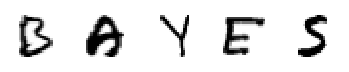

In [42]:
# This helper function prints a sequence of handwritten letters specified by word_idx

def print_word(word_idx):
    f, axarr = plt.subplots(1,len(word_idx))
    for i in range(len(word_idx)):
        axarr[i].imshow(X_test_img[word_idx[i]],cmap='Greys')
        axarr[i].axis('off')
    plt.show()
    
##################
# Test code

letters = letter_idxs()
word_idx = make_word("bayes", letters)
print_word(word_idx)

Finally, we can classify a word using our Random Forest classifier. 

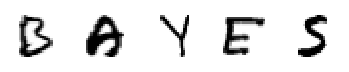

Classification (RF): bayes


In [43]:
# This helper function classifies a sequence of handwritten letters using the RF classifier

def classify_rf(word_idx):
    pred = classifier.predict([X_test[i] for i in word_idx])
    pred_word = ''.join([num_to_letter(i) for i in pred])
    return pred_word

##################
# Test code

print_word(word_idx)
print("Classification (RF):", classify_rf(word_idx))

## Conditional Random Field (CRF)

Let's start coding our CRF model. This model is a Markov network with two kinds of potentials:

1. $\phi_i(Y_i,x_i)$ is the score provided by the classifier for each character image $x_i$. Notice that $Y_i$ is a vector of scores, one for each class (letter).
2. $\phi(Y_i, Y_{i+1})$ is a measure of co-occurrence of consecutive letters. We will use the probability of occurrence of two successive letters in a dictionary. Therefore, we will need to estimate these quantities from the data.

Our first task is to compute $P(y_i, y_{i+1})$. We need a large dataset of words. We can find several of them online. We will use one with [466k English words](https://github.com/dwyl/english-words).

Let's start loading it into memory. It has one word per line.

In [44]:
text_file = open('data/words_alpha.txt', 'r')
word_dataset = text_file.readlines()

Before computing the factors for our CRF, it is interesting to evaluate the accuracy of the RF model to recognise entire words correctly. Let's start by splitting the word dataset into training and test sets.

In [45]:
(W_train, W_test) = train_test_split(word_dataset, test_size=0.01)

The next function will compute the accuracy of the test set. We reserve the training set to compute $\phi(Y_i, Y_{i+1})$ later on.

We define a "word accuracy" as the percentage of words that were correctly recognised in the test set. To be correctly identified, the classifier must correctly recognise every letter. Therefore, we can expect a much lower accuracy for words that the one we got for individual letters.

The next cell may take a while to run.

In [46]:
def word_accuracy(words, letters):
    acc = 0
    for word in words:
        word = word.rstrip()
        w = make_word(word, letters)
        pred_word = classify_rf(w)
        if pred_word == word:
            acc+=1
    return acc/len(words)

###################
# Test code

print("Word accuracy (RF):", word_accuracy(W_test, letters))

Word accuracy (RF): 0.43544030253916804


Indeed, we got an accuracy above 72% for words. It is considerably lower than the one we got for letters (around 97%).

It is time to compute the probability of the occurrence of consecutive letters. We will use the training partition of the word list to compute these probabilities. Let's use Laplace smoothing to avoid zero probabilities.

## Exercise

Implement a function that computes the probability of consecutive letters. We have created a stub for you.

In [37]:
def prob_consecutive_letters(W_train):
    """
    argument 
    `W_train`, a training dataset of words,
    
    Returns a dictionary that maps two-letter strings into an empirical probability of occurrence of these letters
    """
    # Dictionary to map two-letter strings into occurrence counts
    count_letters = {}
    # Lets initialise the disctionary with zero counts
    for two_letters in product(string.ascii_lowercase, string.ascii_lowercase):
        count_letters[''.join(two_letters)] = None                                        # 1 line
    # Now, we scan all words in the training set
    for word in W_train:
        # Remove the \n character
        word = word.rstrip()
        # Finally, we scan every letter in a word and increment the occurrences
        for i in range(len(word)-1):
            count_letters[word[i]+word[i+1]] += None                                      # 1 line
    # Let's compute the total number of occurrence
    total_letters = None                                                                  # 1 line
    # This dictionary has the counts converted into empirical probabilities. Let's use Laplace smoothing to avoid zero values
    prob_letters = {}
    for key, value in count_letters.items():
        # Compute the empirical probabilities from the counts and apply smoothing with k = 1
        prob_letters[key] = None                                                          # 1 line
    return prob_letters

####################
# Test code

prob_letters = prob_consecutive_letters(W_train)
print("P(QU)=", prob_letters["qu"])
print("P(QV)=", prob_letters["qv"])

TypeError: unsupported operand type(s) for +=: 'NoneType' and 'NoneType'

In [47]:
# Answer

def prob_consecutive_letters(W_train):
    """
    argument 
    `W_train`, a training dataset of words,
    
    Returns a dictionary that maps two-letter strings into an empirical probability of occurrence of these letters
    """
    # Dictionary to map two-letter strings into occurrence counts
    count_letters = {}
    # Lets initialise the disctionary with zero counts
    for two_letters in product(string.ascii_lowercase, string.ascii_lowercase):
        count_letters[''.join(two_letters)] = 0
    # Now, we scan all words in the training set
    for word in W_train:
        # Remove the \n character
        word = word.rstrip()
        # Finally, we scan every letter in a word and increment the occurrences
        for i in range(len(word)-1):
            count_letters[word[i]+word[i+1]] += 1
    # Let's compute the total number of occurrence
    total_letters = sum(count_letters.values())
    # This dictionary has the counts converted into empirical probabilities. Let's use Laplace smoothing to avoid zero values
    prob_letters = {}
    for key, value in count_letters.items():
        # Compute the empirical probabilities from the counts and apply smoothing with k = 1
        prob_letters[key] = (value + 1) / (total_letters + len(letters) ** 2)
    return prob_letters

####################
# Test code

prob_letters = prob_consecutive_letters(W_train)
print("P(QU)=", prob_letters["qu"])
print("P(QV)=", prob_letters["qv"])

P(QU)= 0.0018448312082868731
P(QV)= 9.696029475929608e-07


If your code is correct, you should see an output similar to this one (the exact values will differ because of the random partitions of the data)

```
P(QU)= 0.0018416920553839273
P(QV)= 9.696518368114745e-07
``` 

We can use `prob_consecutive_letter` function to create a factor $\phi(Y_i, Y_{i+1})$. We will call these factor a "transition" factor since it quantifies the strength of transitioning between consecutive letters. This factor is quite large since it stores $26^2$ entries expressing the transition probabilities between all possible pairs of letters.

The next function, `transition_factor`, returns such a factor in the format defined in the previous tutorials (dictionary with 'dom' and 'table'). Therefore, we will be able to reuse our code to operate over these factors.

## Exercise

Let's implement the function `transition_factor`. We will use log-probabilities to avoid underflow issues. We have implemented part of the code for you.

In [48]:
outcomeSpace = {
    'L_t-1':('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'),
    'L_t':('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'),
}

def transition_factor(W_train, outcomeSpace, gamma= .1):
    """
    argument 
    `W_train`, a training dataset of words,
    `outcomeSpace`, a dictionary with variables and their scope
    `gamma`, a parameters to adjust the influence of the transition_factors
    
    Returns a transition factor that expresses hte correlation between two consecutive letters. The values are log-probabilities of occurrence of consecutive letters
    """
    # Call prob_consecutive_letters to compute the probabilities
    prob_letters = None                                                                   # 1 line
    # Create an empty factor
    tFactor = {'dom': ('L_t-1', 'L_t'), 'table': odict([])}
    for letters in product(outcomeSpace['L_t'], outcomeSpace['L_t-1']):
        # Populate the factor with log-probabilities multiplied by the parameter gamma. Use math.log2
        tFactor['table'][letters] = None                                                  # 1 line
    return tFactor

In [50]:
# Answer

outcomeSpace = {
    'L_t-1':('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'),
    'L_t':('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'),
}

def transition_factor(W_train, outcomeSpace, gamma= .1):
    """
    argument 
    `W_train`, a training dataset of words,
    `outcomeSpace`, a dictionary with variables and their scope
    `gamma`, a parameters to adjust the influence of the transition_factors
    
    Returns a transition factor that expresses hte correlation between two consecutive letters. The values are log-probabilities of occurrence of consecutive letters
    """
    # Call prob_consecutive_letters to compute the probabilities
    prob_letters = prob_consecutive_letters(W_train)
    # Create an empty factor
    tFactor = {'dom': ('L_t-1', 'L_t'), 'table': odict([])}
    for letters in product(outcomeSpace['L_t'], outcomeSpace['L_t-1']):
        # Populate the factor with log-probabilities multiplied by the parameter gamma. Use math.log2
        tFactor['table'][letters] = gamma * math.log2(prob_letters[''.join(letters)])
    return tFactor

Similarly, we define a function to create the factors $\phi_i(Y_i, x_i)$. We call these "classification factors". There will be one of those factors for each input character. 

## Exercise 

Let's implement the `classification_factors` function. This function receives a list of indexes with the position of the letters in the test set. For each letter, we will create one factor. This factor has the log-probabilities assigned by a classifier to each class. 

We have already started the code for you.

In [51]:
def classificationFactors(word_idx):
    """
    argument 
    `word_idx`, a list with test set indexes for each letter that form a word
    
    Returns a list of classification factors. Each factor has the probabilities assigned by a classifier to each letter and class
    """    
    np.seterr(divide = 'ignore') 
    # Class classifier.predict_log_proba to return the log-probabilities for each letter in word_idx
    log_prob = None                                                       # 1 line with list comprehension
    np.seterr(divide = 'warn') 
    # This variable has the list of factors we will return. We start with an empty list
    factors = []    
    for i in range(len(word_idx)):
        # Create an empty factor
        F = {'dom': ('L_t-1',), 'table': odict([])}
        for letter in outcomeSpace['L_t']:
            # Populate the factor with the log-probabilities in log_prob
            F['table'][tuple(letter)] = None                              # 1 line
        factors.append(F)
    return factors

In [52]:
# Answer

def classificationFactors(word_idx):
    """
    argument 
    `word_idx`, a list with test set indexes for each letter that form a word
    
    Returns a list of classification factors. Each factor has the probabilities assigned by a classifier to each letter and class
    """    
    np.seterr(divide = 'ignore') 
    # Class classifier.predict_log_proba to return the log-probabilities for each letter in word_idx
    log_prob = classifier.predict_log_proba([X_test[i] for i in word_idx])
    np.seterr(divide = 'warn') 
    # This variable has the list of factors we will return. We start with an empty list
    factors = []    
    for i in range(len(word_idx)):
        # Create an empty factor
        F = {'dom': ('L_t-1',), 'table': odict([])}
        for letter in outcomeSpace['L_t']:
            # Populate the factor with the log-probabilities in log_prob
            F['table'][tuple(letter)] = log_prob[i][ord(letter)-ord('a')]
        factors.append(F)
    return factors

Now, we will need some functions we defined in the previous tutorials. We start with `prob` and `maximize`. We pasted our implementations of these functions. Feel free to replace them with your versions.

In [53]:
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """

    return factor['table'][entry]     # insert your code here, 1 line   

def maximize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be maximized out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        m = float("-inf");                    # Initialize the maximization variable m. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)

            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 1 line
            m = max(m, p)                        # Maximize over all values of var by storing the max value in m. 1 line
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, m))
    return {'dom': tuple(new_dom), 'table': odict(table)}

The next three functions implement the Viterbi algorithm for CRFs. They are almost trivial adaptations of the same functions we implemented for Hidden Markov Models. For instance, instead of expecting transition and emission probabilities, these functions expect as input transition and classification factors. 

In [54]:
def viterbiOnline(f, tFactor, cFactor, outcomeSpace):
    """
    argument 
    `f`, factor that represents the previous state.
    `tFactor`, transition factor from time t-1 to t.
    `cFactor`, classification factor.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a new factor that represents the current state.
    """ 

    # Set fCurrent as a copy of f
    fCurrent = f.copy();
    # Set the f_previous domain to be a list with a single variable name appended with '_t-1' to indicate previous time step
    fCurrent['dom'] = ('L_t-1', )       
    # Make the join operation between fCurrent and the transition probability table
    fCurrent = join(fCurrent, tFactor, outcomeSpace)
    # Eliminate the randVariable_t-1 with the maximization operation
    fCurrent = maximize(fCurrent, fCurrent['dom'][0], outcomeSpace)
    fCurrent['dom'] = ('L_t-1', )    
    fCurrent = join(fCurrent, cFactor, outcomeSpace)
    return fCurrent

def viterbiBatch(tFactor, cFactors, outcomeSpace):
    """
    argument 
    `tFactor`, transition factor from time t-1 to t.
    `cFactors`, a list of classification factors.
    `outcomeSpace`, dictionary with the domain of each variable.
    
    Returns a list with all intermediate factors computed by the Viterbi algorithm.
    """
    
    # Set fCurrent as a copy of f
    fCurrent = cFactors[0].copy()
    timeLine = [fCurrent]
    for i in range(1,len(cFactors)):
        # Call the online version of the Viterbi algorithm to update one time step
        fCurrent = viterbiOnline(fCurrent, tFactor, cFactors[i], outcomeSpace)
        # Print the current factor for debugging
        timeLine.append(fCurrent)
    return timeLine

def traceBack(timeLine, tFactor, cFactors, outcomeSpace, eps = .000000001):
    """
    argument
    `timeLine`, a list with all intermediate factors computed by the Viterbi algorithm.
    `tFactor`, transition factor from time t-1 to t.
    `cFactors`, a list of classification factors.
    `outcomeSpace`, dictionary with the domain of each variable.
    `eps`, a threshold to compare float numbers
    
    Returns a list with the MLE assignment.
    """ 

    t = len(timeLine) - 1
    mleList = [outcomeSpace['L_t'][0]] * (t+1)
    mleList[t] = max(timeLine[t]['table'], key=timeLine[t]['table'].get)[0]
    p = prob(timeLine[t], mleList[t])
    for t in range(t,0,-1):
        p_c = prob(cFactors[t], mleList[t])
        for state in outcomeSpace['L_t']:
            p_t = prob(tFactor, state, mleList[t])
            if abs((prob(timeLine[t-1], state)) - (p - p_c - p_t)) < eps:
                mleList[t-1] = state
                p = prob(timeLine[t-1], state)
                break
    return mleList

The last piece of code we need from our previous tutorials is the `join` function. However, as we are working with log-probabilities, you will need to make a straightforward adaptation. The next cell is reserved for that.

## Exercise

Copy your implementation of the `join` function from previous tutorials and adapt it to work with log-probabilities.

In [55]:
def join(f1, f2, outcomeSpace):
    None

In [56]:
# Answer

def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 + p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}

We are finally in a position to use the CRF to classify words. The approach is to use the Viterbi algorithm and return the MPE assignment. The next function will perform this task.

## Exercise

Implement the `classify_crf` function that uses the Viterbi algorithm to classify a word represented by a list of indexes.

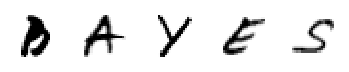

TypeError: can only join an iterable

In [57]:
def classify_crf(word_idx, tfactor, outcomeSpace):
    """
    argument 
    `word_idx`, a list of word indexes representing letter in the test set.
    `tfactor`, pre-computed transition factor.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a word predicted by the CRF model
    """
    # Compute the classification factors for word_idx
    cFactors = None                                                                    # 1 line
    # Use Viterbi algorithm to compute the time line
    timeLine = None                                                                    # 1 line
    # Obtain the MPE assigment from the time line
    mpe = None                                                                         # 1 line
    pred_word = ''.join(mpe)
    return pred_word

##################
# Test code

letters = letter_idxs()
tfactor = transition_factor(W_train, outcomeSpace)
word_idx = make_word("bayes", letters)
print_word(word_idx)
print(classify_crf(word_idx, tfactor, outcomeSpace))

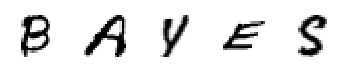

bayes


In [59]:
# Answer

def classify_crf(word_idx, tfactor, outcomeSpace):
    """
    argument 
    `word_idx`, a list of word indexes representing letter in the test set.
    `tfactor`, pre-computed transition factor.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a word predicted by the CRF model
    """
    # Compute the classification factors for word_idx
    cFactors = classificationFactors(word_idx)
    # Use Viterbi algorithm to compute the time line
    timeLine = viterbiBatch(tfactor, cFactors, outcomeSpace)
    # Obtain the MPE assigment from the time line
    mpe = traceBack(timeLine, tfactor, cFactors, outcomeSpace)
    pred_word = ''.join(mpe)
    return pred_word

##################
# Test code

letters = letter_idxs()
tfactor = transition_factor(W_train, outcomeSpace)
word_idx = make_word("bayes", letters)
print_word(word_idx)
print(classify_crf(word_idx, tfactor, outcomeSpace))

As the last step, we can compare the classification accuracy of Random Forest and Conditional Random Field. The next function will perform this task.

## Exercise

Implement `compare_acc` to compute the accuracy of RF and CRM in the test set partition of the word dataset.

The next cell will take a while to run.

In [60]:
def compare_acc(W_train, W_test, outcomeSpace):
    """
    argument 
    `W_train`, the training set partition of the word dataset.
    `W_test`, the test set partition of the word dataset.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a word predicted by the CRF model
    """    
    acc_rf = 0
    acc_crf = 0
    # Compute the letter indexes by calling the appropriate function
    letters = None                                                                     # 1 line
    # Compute the transition factor 
    tFactor = transition_factor(W_train, outcomeSpace)
    for word in W_test:
        word = word.rstrip()
        # Transform the word string in a list of letter indexes
        word_idx = None                                                                # 1 line
        # Classify word_idx using the CRF model
        word_crf = None                                                                # 1 line
        # Classify word_idx using the RF model
        word_rf = None                                                                 # 1 line
        if word_rf == word:
            acc_rf += 1
        if word_crf == word:
            acc_crf += 1
    return [acc_rf/len(W_test), acc_crf/len(W_test)]

##################
# Test code

[acc_rf, acc_crf] = compare_acc(W_train, W_test, outcomeSpace)
print("Accuracy RF:", acc_rf)
print("Accuracy CRF:", acc_crf)

Accuracy RF: 0.0
Accuracy CRF: 0.0


In [61]:
# Answer

def compare_acc(W_train, W_test, outcomeSpace):
    """
    argument 
    `W_train`, the training set partition of the word dataset.
    `W_test`, the test set partition of the word dataset.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a word predicted by the CRF model
    """    
    acc_rf = 0
    acc_crf = 0
    # Compute the letter indexes by calling the appropriate function
    letters = letter_idxs()
    # Compute the transition factor 
    tFactor = transition_factor(W_train, outcomeSpace)
    for word in W_test:
        word = word.rstrip()
        # Transform the word string in a list of letter indexes
        word_idx = make_word(word, letters)
        # Classify word_idx using the CRF model
        word_crf = classify_crf(word_idx, tfactor, outcomeSpace)
        # Classify word_idx using the RF model
        word_rf = classify_rf(word_idx)
        if word_rf == word:
            acc_rf += 1
        if word_crf == word:
            acc_crf += 1
    return [acc_rf/len(W_test), acc_crf/len(W_test)]

##################
# Test code

[acc_rf, acc_crf] = compare_acc(W_train, W_test, outcomeSpace)
print("Accuracy RF:", acc_rf)
print("Accuracy CRF:", acc_crf)

Accuracy RF: 0.43246893571042677
Accuracy CRF: 0.6080497028633172


If your implementation is correct, you should see a significant improvement in classification accuracy. The CRF model should perform around 80% accuracy, while the RF has about 73%. (On the small dataset, accuracy should be about 43% and 60%). 

That is all for today. See you next week!